In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -uq "/content/drive/MyDrive/HACKATHON 2020/Autoencoder/spectrograms.zip" -d "/content/drive/MyDrive/HACKATHON 2020/Autoencoder"

In [5]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
train_path = '/content/drive/MyDrive/HACKATHON 2020/Autoencoder/train/'
test_path = '/content/drive/MyDrive/HACKATHON 2020/Autoencoder/test/'

In [23]:
num_images = len(os.listdir(train_path + 'neg/'))
img_height = 448
img_width = 448
channels = 1

print('Total number of images in training set: {}'.format(num_images))

Total number of images in training set: 2158


In [24]:
df = []
for idx, filename in enumerate(os.listdir(train_path + 'neg/')):

    image_path = os.path.join(train_path + 'neg/', filename)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, size = [img_height,img_width])
    image = image.numpy()/255.
    # image = image[:,:, 0] ---> Delete the channel dimension
    df.append(image)

x_train = np.array(df).astype('float32')
x_val = x_train[int(num_images*0.9):,:,:,:]
x_train = x_train[0:int(num_images*0.9),:,:,:]

print(x_train.shape, x_val.shape)

(1942, 448, 448, 1) (216, 448, 448, 1)


In [25]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [26]:
conv_shape = (3, 3)

input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(channels, conv_shape, activation='sigmoid', padding='same')(x)

In [27]:
encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 448, 448, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 448, 448, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 8)       1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 112, 112, 8)       0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [28]:
autoencoder = Model(input_img, decoded, name='convolutional_autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 448, 448, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 448, 448, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 8)       1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 8)       584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 224, 

In [29]:
es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

'''
model_path = "/content/drive/MyDrive/HACKATHON 2020/Autoencoder/Autoencoder_covid.h5"
mc_cb = ModelCheckpoint(model_path,
                        save_best_only=True,
                        verbose = True)
'''

cb = [es_cb, lr_cb]

In [30]:
epochs = 500
batch_size = 32

autoencoder_train = autoencoder.fit(x=x_train, y=x_train,
                                    batch_size=batch_size,
                                    epochs=epochs, 
                                    shuffle=True,
                                    validation_data=(x_val, x_val),
                                    callbacks=cb)

Epoch 1/500
61/61 [==============================] - 17s 168ms/step - loss: 0.1176 - val_loss: 0.0099
Epoch 2/500
61/61 [==============================] - 9s 151ms/step - loss: 0.0084 - val_loss: 0.0028
Epoch 3/500
61/61 [==============================] - 9s 154ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/500
61/61 [==============================] - 9s 155ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/500
61/61 [==============================] - 10s 157ms/step - loss: 0.0011 - val_loss: 9.8142e-04
Epoch 6/500
61/61 [==============================] - 10s 159ms/step - loss: 9.3614e-04 - val_loss: 8.6030e-04
Epoch 7/500
61/61 [==============================] - 10s 159ms/step - loss: 8.2938e-04 - val_loss: 7.7912e-04
Epoch 8/500
61/61 [==============================] - 9s 156ms/step - loss: 7.5418e-04 - val_loss: 7.2254e-04
Epoch 9/500
61/61 [==============================] - 9s 155ms/step - loss: 7.1136e-04 - val_loss: 6.8052e-04
Epoch 10/500
61/61 [==============================]

In [31]:
model_path = "/content/drive/MyDrive/HACKATHON 2020/Autoencoder/"

saved = False
if not saved:
    autoencoder.save(model_path + 'cae_model.hdf5')
    encoder.save(model_path + 'cae_encoder.hdf5')    
    saved = True

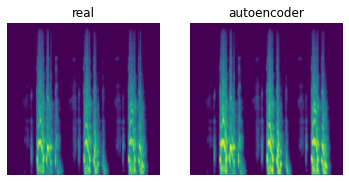

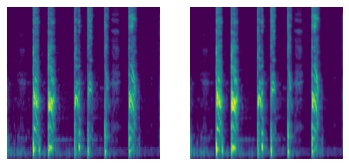

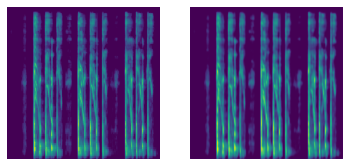

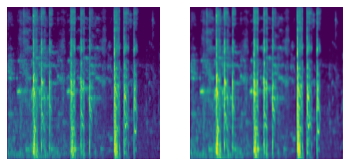

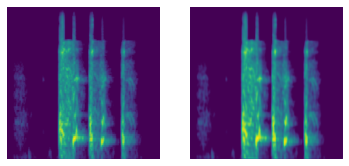

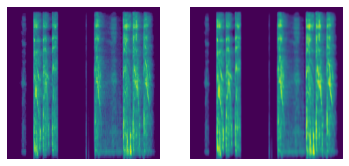

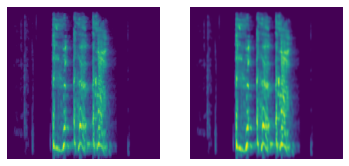

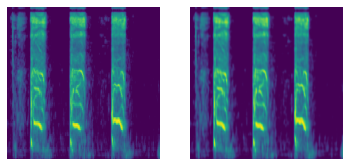

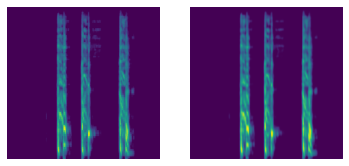

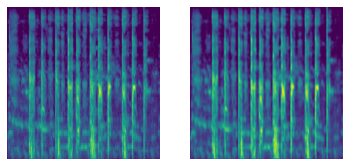

In [32]:
ind_test = np.random.choice(range(x_val.shape[0]), 10)
test_images = np.take(x_val, ind_test, axis=0)
preds = autoencoder.predict(test_images)

has_title = False
for im, pred in zip(test_images, preds):
    plt.figure()
    
    ax1 = plt.subplot(1,2,1)
    plt.imshow(np.squeeze(im))
    
    ax2 = plt.subplot(1,2,2)
    plt.imshow(np.squeeze(pred))
    
    ax1.axis('off')
    ax2.axis('off')    
    if not has_title:
        ax1.set_title('real')
        ax2.set_title('autoencoder')
        has_title = True

In [33]:
df2 = []
for idx, filename in enumerate(os.listdir(test_path + 'neg/')):

    image_path = os.path.join(test_path + 'neg/', filename)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, size = [img_height,img_width])
    image = image.numpy()/255.
    # image = image[:,:, 0] ---> Delete the channel dimension
    df2.append(image)

x_test_neg = np.array(df2).astype('float32')
print(x_test_neg.shape)

df3 = []
for idx, filename in enumerate(os.listdir(test_path + 'pos/')):

    image_path = os.path.join(test_path + 'pos/', filename)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, size = [img_height,img_width])
    image = image.numpy()/255.
    # image = image[:,:, 0] ---> Delete the channel dimension
    df3.append(image)

x_test_pos = np.array(df3).astype('float32')
print(x_test_pos.shape)

(151, 448, 448, 1)
(152, 448, 448, 1)


In [34]:
reconstructions_neg = autoencoder.predict(x_test_neg)
reconstructions_pos = autoencoder.predict(x_test_pos)

In [35]:
mse_neg = np.mean(np.power(x_test_neg[:,:,:,0] - reconstructions_neg[:,:,:,0], 2), axis = (1,2))
mse_pos = np.mean(np.power(x_test_pos[:,:,:,0] - reconstructions_pos[:,:,:,0], 2), axis = (1,2))

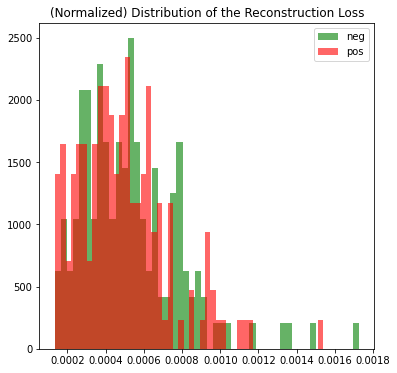

In [36]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(mse_neg, bins=50, density=True, label="neg", alpha=.6, color="green")
ax.hist(mse_pos, bins=50, density=True, label="pos", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

(152, 224)